In [2]:
import os
import glob
import re
import itertools
import time

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = -1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import parsl
from parsl.config import Config
from parsl.executors import HighThroughputExecutor

config = Config(
    executors=[
        HighThroughputExecutor(max_workers=40)
    ],
    strategy=None
)
parsl.load(config)

from src.utils import get_consensus

In [3]:
benchmarking_dir = '/cephfs/users/annawoodard/gene-fusion/FusionBenchmarking'
analysis_tag = 'sim_50'
analysis_dir = 'simulated_data/{}'.format(analysis_tag)
ctat_dir = '/cephfs/users/annawoodard/gene-fusion/GRCh38_gencode_v31_CTAT_lib_Oct012019.plug-n-play/ctat_genome_lib_build_dir'

In [4]:
command = (
    "docker run -v {}:/data trinityctat/fusionbenchmarking "
    "bash -c "
    "'find /data/{}/samples -type f | /data/util/make_file_listing_input_table.pl'"
).format(benchmarking_dir, analysis_dir)

!$command > $benchmarking_dir/$analysis_dir/simulated_datafusion_result_file_listing.dat

In [5]:
command = (
    "docker run -v {}:/data trinityctat/fusionbenchmarking "
    "bash -c "
    "'/usr/local/src/FusionBenchmarking/benchmarking/collect_preds.pl "
    "/data/{}/simulated_datafusion_result_file_listing.dat'"
).format(benchmarking_dir, analysis_dir)
!$command > $benchmarking_dir/$analysis_dir/preds.collected

In [6]:
command = (
    "docker run -v {}:/data trinityctat/fusionbenchmarking "
    "bash -c '"
    "/usr/local/src/FusionBenchmarking/benchmarking/map_gene_symbols_to_gencode.pl "
    "/data/{}/preds.collected "
    "/data/resources/genes.coords.gz /data/resources/genes.aliases'"
).format(benchmarking_dir, analysis_dir)

!$command > $benchmarking_dir/$analysis_dir/preds.collected.gencode_mapped

-parsing annotation gene spans
-warning, no gene stored for identifier: [V]
-warning, no gene stored for identifier: [x]
-warning, no gene stored for identifier: [C7ORF55-LUC7L2]
-warning, no gene stored for identifier: [C5ORF67]
-warning, no gene stored for identifier: [C17ORF112]
-warning, no gene stored for identifier: [CDP-diacylglycerol]
-warning, no gene stored for identifier: [snoU13]


In [ ]:
!docker run -v /cephfs/users/annawoodard/gene-fusion/GRCh38_gencode_v31_CTAT_lib_Oct012019.plug-n-play/ctat_genome_lib_build_dir:/ctat_genome_lib_build_dir -v /cephfs/users/annawoodard/gene-fusion/data/interim/fusions.tsv:/fusions.tsv trinityctat/starfusion:1.8.0 /usr/local/src/STAR-Fusion/FusionInspector/FusionAnnotator/FusionAnnotator --annotate /fusions.tsv --full --genome_lib_dir /ctat_genome_lib_build_dir/ > /cephfs/users/annawoodard/gene-fusion/data/interim/annotated_fusions.tsv

In [7]:
command = (
    "docker run "
    "-v {}:/ctat_genome_lib_build_dir "
    "-v {}:/data "
    "trinityctat/fusionbenchmarking "
    "bash -c '"
    "FusionAnnotator/FusionAnnotator "
    "--annotate /data/{}/preds.collected.gencode_mapped -C 2 --genome_lib_dir /ctat_genome_lib_build_dir/'"
).format(ctat_dir, benchmarking_dir, analysis_dir)

!$command > $benchmarking_dir/$analysis_dir/preds.collected.gencode_mapped.wAnnot

In [8]:
command = (
    "docker run -v {}:/data trinityctat/fusionbenchmarking "
    "bash -c "
    "'/usr/local/src/FusionBenchmarking/benchmarking/filter_collected_preds.pl "
    "/data/{}/preds.collected.gencode_mapped.wAnnot'"
).format(benchmarking_dir, analysis_dir)
!$command > $benchmarking_dir/$analysis_dir/preds.collected.gencode_mapped.wAnnot.filt

In [9]:
command = (
    "docker run -v {}/..:/data trinityctat/fusionbenchmarking "
    "bash -c "
    "'chmod -R a+w /data/FusionBenchmarking/{}'"
).format(benchmarking_dir, analysis_dir)
!$command

In [10]:
predictions = pd.read_csv(
    os.path.join(benchmarking_dir, analysis_dir, 'preds.collected.gencode_mapped.wAnnot.filt'),
    sep='\t',
    skiprows=1,
    header=None,
    names=['sample', 'prog', 'fusion', 'J', 'S', 'mapped_gencode_A_gene_list', 'mapped_gencode_B_gene_list', 'annotations']
)

In [11]:
predictions['gene_a'] = [sorted(i.split(','))[0] for i in predictions.mapped_gencode_A_gene_list]
predictions['gene_b'] = [sorted(i.split(','))[0] for i in predictions.mapped_gencode_B_gene_list]
predictions['normalized_fusion'] = predictions[['gene_a', 'gene_b']].apply(lambda x: '--'.join(sorted(x)), axis=1)
predictions['sum_J_S'] = predictions.J + predictions.S

In [12]:
samples = sorted(predictions['sample'].unique())
fusion_sets = pd.DataFrame(data={
    'prog': [
        prog 
        for prog in sorted(predictions.prog.unique())
        for sample in samples
    ],
    'sample': [
        sample
        for prog in sorted(predictions.prog.unique())
        for sample in samples
    ],
    'fusion_set': [
        set(
            predictions[
                (predictions['sample'] == sample) & 
                (predictions['prog'] == prog)
            ]['normalized_fusion'].unique()
        ) 
        for prog in sorted(predictions.prog.unique())
        for sample in samples
    ]
}
)

In [28]:
predictions[:10]

,sample,prog,fusion,J,S,mapped_gencode_A_gene_list,mapped_gencode_B_gene_list,annotations,gene_a,gene_b,normalized_fusion,sum_J_S
0,sim_adipose,TrinityFusion-UC,CWC22--CAPS,3106,9681,CWC22,"AC104532.1,AC104532.2,AC104532.4,CAPS,RANBP3","[""INTERCHROMOSOMAL[chr2--chr19]""]",CWC22,AC104532.1,AC104532.1--CWC22,12787
1,sim_adipose,TrinityFusion-UC,CWC22--AC104532.2,3106,9681,CWC22,"AC104532.1,AC104532.2,AC104532.4,CAPS,VMAC","[""INTERCHROMOSOMAL[chr2--chr19]""]",CWC22,AC104532.1,AC104532.1--CWC22,12787
2,sim_adipose,TrinityFusion-UC,WFDC5--MLF1,3041,9583,WFDC5,MLF1,"[""INTERCHROMOSOMAL[chr20--chr3]""]",WFDC5,MLF1,MLF1--WFDC5,12624
3,sim_adipose,TrinityFusion-UC,LRIT1--KIAA1377,2883,9367,LRIT1,"ANGPTL5,CEP126,KIAA1377",[],LRIT1,ANGPTL5,ANGPTL5--LRIT1,12250
4,sim_adipose,TrinityFusion-UC,PID1--DAP,2831,8798,"7SK,7SK.289,AC007677.1,AC007677.2,PID1,RN7SKP283","AC012629.2,CTD-2154B17.4,DAP","[""INTERCHROMOSOMAL[chr2--chr5]""]",7SK,AC012629.2,7SK--AC012629.2,11629
5,sim_adipose,TrinityFusion-UC,TPM2--RAPH1,2671,8499,TPM2,"ABI2,RAPH1","[""INTERCHROMOSOMAL[chr9--chr2]""]",TPM2,ABI2,ABI2--TPM2,11170
6,sim_adipose,TrinityFusion-UC,NLN--TSFM,2710,8403,"AC008958.1,CTD-2353N24.1,NLN,SGTB","AC025165.1,AC025165.3,AC025165.5,AVIL,EEF1AKMT...","[""INTERCHROMOSOMAL[chr5--chr12]""]",AC008958.1,AC025165.1,AC008958.1--AC025165.1,11113
7,sim_adipose,TrinityFusion-UC,NLN--RP11-571M6.15,2710,8403,"AC008958.1,CTD-2353N24.1,NLN,SGTB","AC025165.1,AC025165.3,EEF1AKMT3,METTL21B,RP11-...",[],AC008958.1,AC025165.1,AC008958.1--AC025165.1,11113
8,sim_adipose,TrinityFusion-UC,PPT1--PHF5A,2681,8387,"CAP1,PPT1",PHF5A,"[""INTERCHROMOSOMAL[chr1--chr22]""]",CAP1,PHF5A,CAP1--PHF5A,11068
9,sim_adipose,TrinityFusion-UC,CTSK--AP3M1,2724,8336,"CTSK,UBE2D3P3","AP3M1,RP11-178G16.4,RP11-178G16.5","[""INTERCHROMOSOMAL[chr1--chr10]""]",CTSK,AP3M1,AP3M1--CTSK,11060


In [13]:
auc = pd.read_csv(
    os.path.join(benchmarking_dir, analysis_dir, '__analyze_strict/all.AUC.dat'),
    sep='\t',
    header=None,
    names=['prog', 'auc']
)

progs = auc.prog.unique()
mean_auc = pd.DataFrame(data={
    'prog': progs,
    'mean_auc': [auc[auc.prog == prog].mean()[0] for prog in progs]
    }
)

In [14]:
mean_auc

,prog,mean_auc
0,quorum_2(top_4),0.788
1,quorum_2(top_5),0.782
2,quorum_2(top_6),0.800
3,union_STARSEQR_quorum_2(top_4),0.788
4,union_STARSEQR_quorum_2(top_5),0.782
5,union_STARSEQR_quorum_5(top_5),0.760
6,STARSEQR,0.760
7,ChimPipe,0.718
8,quorum_3(top_5),0.758
9,union_STARSEQR_quorum_3(top_5),0.762


In [16]:
start = time.time()

top_prog = mean_auc.sort_values(by='mean_auc', ascending=False)['prog'][0]

futures = []
for num_progs in range(2, 10):
    top_progs = mean_auc.sort_values(by='mean_auc', ascending=False)['prog'][:num_progs]
    for quorum in range(2, num_progs + 1):
        futures += [
            (
                get_consensus(
                    fusion_sets[
                        (fusion_sets['sample'] == sample) & 
                        (fusion_sets['prog'].str.contains('|'.join(top_progs)))
                    ].fusion_set.to_list(),
                    quorum
                ),
                sample,
                top_progs,
                quorum
            )
            for sample in samples
        ]

ensemble_predictions = []
for f, sample, top_progs, quorum in futures:
    ensemble_fusions = list(f.result())
    
    indices = [
        predictions[
            (predictions['sample'] == sample) &
            (predictions['normalized_fusion'] == ensemble_fusions[i]) &
            (predictions['prog'].str.contains('|'.join(top_progs)))
        ].sum_J_S.idxmax()
        for i in range(len(ensemble_fusions))
    ]
    ensemble_predictions.append(predictions.loc[indices])
    prog = 'quorum_{}(top_{})'.format(quorum, len(top_progs))
    ensemble_predictions[-1].prog = prog
    print('finished {} ({} fusions for {}) in {:.0f} seconds'.format(prog, len(indices), sample, time.time() - start))
    
    union_ensemble_fusions = list(set.union(
        fusion_sets[
            (fusion_sets['sample'] == sample) & 
            (fusion_sets['prog'] == top_prog)
        ].fusion_set.to_list()[0],
        ensemble_fusions
    ))
    
    indices = [
        predictions[
            (predictions['sample'] == sample) &
            (predictions['normalized_fusion'] == union_ensemble_fusions[i]) &
            (predictions['prog'].str.contains('|'.join(top_progs)))
        ].sum_J_S.idxmax()
        for i in range(len(union_ensemble_fusions))
    ]
    ensemble_predictions.append(predictions.loc[indices])
    prog = 'union_{}_quorum_{}(top_{})'.format(top_prog, quorum, len(top_progs))
    ensemble_predictions[-1].prog = prog
    
    print('finished {} ({} fusions) in {:.0f} seconds'.format(prog, len(indices), time.time() - start))

print('finished in {:.0f} seconds'.format(time.time() - start))

finished quorum_2(top_2) (0 fusions for sim_adipose) in 1 seconds


IndexError: list index out of range

In [17]:
predictions = pd.concat([predictions] + ensemble_predictions)

In [18]:
predictions.to_csv(
    os.path.join(benchmarking_dir, analysis_dir, 'preds.collected.gencode_mapped.wAnnot.filt'),
    sep='\t',
    index=False,
    columns=['sample', 'prog', 'fusion', 'J', 'S', 'mapped_gencode_A_gene_list', 'mapped_gencode_B_gene_list', 'annotations']
)

In [19]:
command = (
    "docker run -v {}/..:/data trinityctat/fusionbenchmarking "
    "bash -c "
    "'rm -rf /data/FusionBenchmarking/{}/__*'"
).format(benchmarking_dir, analysis_dir)
!$command

In [20]:
command = (
    "docker run -v {}/..:/data trinityctat/fusionbenchmarking "
    "bash -c "
    "'cd /data/FusionBenchmarking/{}; "
    "/data/FusionBenchmarking/simulated_data/analyze_simulated_data.pl "
    "{}.truth_set.dat {}.fusion_TPM_values.dat'"
).format(benchmarking_dir, analysis_dir, analysis_tag, analysis_tag)
!$command

-- Skipping CMD: find ./samples -type f | /data/FusionBenchmarking/simulated_data/../util/make_file_listing_input_table.pl  > fusion_result_file_listing.dat, checkpoint exists.
-- Skipping CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/collect_preds.pl fusion_result_file_listing.dat > preds.collected, checkpoint exists.
-- Skipping CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/map_gene_symbols_to_gencode.pl  preds.collected  /data/FusionBenchmarking/simulated_data/../resources/genes.coords.gz  /data/FusionBenchmarking/simulated_data/../resources/genes.aliases  > preds.collected.gencode_mapped , checkpoint exists.
-- Skipping CMD: /usr/local/src/FusionAnnotator/FusionAnnotator --annotate preds.collected.gencode_mapped  -C 2 > preds.collected.gencode_mapped.wAnnot, checkpoint exists.
-- Skipping CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/filter_collected_preds.pl preds.collected.gencode_mapped.wAnnot > preds.collected.gencode_mapped.wAnnot.f


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/plotters/plot_TP_FP_vs_minSum_per_prog.R fusion_preds.txt.scored.ROC

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/calc_PR.py --in_ROC fusion_preds.txt.scored.ROC --out_PR fusion_preds.txt.scored.PR | sort -k2,2gr | tee fusion_preds.txt.scored.PR.AUC
ARRIBA	0.78
STARSEQR	0.78
STAR_FUSION_v1.5	0.75
PIZZLY	0.72
ChimPipe	0.70
SOAP-fuse	0.69
FUSIONCATCHER_v1.10_June192019	0.67
ChimeraScan	0.64
PRADA	0.64
ARRIBA_hc	0.63
InFusion	0.63
MapSplice	0.63
FUSION_CATCHER_V0994e	0.60
EricScript	0.58
TopHat-Fusion	0.5

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/plotters/plot_F1_vs_min_frags.R fusion_preds.txt.scored.ROC

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/plotters/plot_TP_FP_vs_minSum_per_prog.R fusion_preds.txt.scored.ROC

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/calc_PR.py --in_ROC fusion_preds.txt.scored.ROC --out_PR fusion_preds.txt.scored.PR | sort -k2,2gr | tee fusion_preds.txt.scored.PR.AUC
ARRIBA	0.76
STARSEQR	0.76
ChimPipe	0.74
STAR_FUSION_v1.5	0.73
PIZZLY	0.72
ChimeraScan	0.70
SOAP-fuse	0.68
FUSIONCATCHER_v1.10_

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/plotters/plot_F1_vs_min_frags.R all.scored.preds.ROC

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/plotters/plot_TP_FP_vs_minSum_per_prog.R all.scored.preds.ROC

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/calc_PR.py --in_ROC all.scored.preds.ROC --out_PR all.scored.preds.PR | sort -k2,2gr | tee all.scored.preds.PR.AUC
ARRIBA	0.77
STARSEQR	0.76
STAR_FUSION_v1.5	0.73
ChimPipe	0.72
PIZZLY	0.72
SOAP-fuse	0.69
ChimeraScan	0.68
FUSIONCATCHER_v1.10_June192019	0.68
PRADA	0.68
ARRIBA_h

ChimeraScan	sim_colon	1	30	120	25.00%
ChimeraScan	sim_brain	1	25	97	25.77%
ChimeraScan	sim_adipose	1	28	84	33.33%
ChimeraScan	sim_heart	1	23	102	22.55%
ChimeraScan	sim_testis	1	36	127	28.35%
ChimeraScan	sim_colon	2	17	34	50.00%
ChimeraScan	sim_brain	2	20	35	57.14%
ChimeraScan	sim_adipose	2	19	35	54.29%
ChimeraScan	sim_heart	2	25	51	49.02%
ChimeraScan	sim_testis	2	14	22	63.64%
ChimeraScan	sim_colon	3	29	41	70.73%
ChimeraScan	sim_brain	3	25	38	65.79%
ChimeraScan	sim_adipose	3	29	48	60.42%
ChimeraScan	sim_heart	3	25	37	67.57%
ChimeraScan	sim_testis	3	25	40	62.50%
ChimeraScan	sim_colon	4	21	27	77.78%
ChimeraScan	sim_brain	4	35	52	67.31%
ChimeraScan	sim_adipose	4	23	30	76.67%
ChimeraScan	sim_heart	4	23	30	76.67%
ChimeraScan	sim_testis	4	17	23	73.91%
ChimeraScan	sim_colon	5	25	31	80.65%
ChimeraScan	sim_brain	5	37	45	82.22%
ChimeraScan	sim_adipose	5	29	37	78.38%
ChimeraScan	sim_heart	5	36	45	80.00%
ChimeraScan	sim_testis	5	24	29	82.76%
ChimeraScan	sim_colon	6	36	41	87.80%
ChimeraScan	sim_brai

CMD: R --no-save --no-restore --no-site-file --no-init-file -q < all.scored.preds.sensitivity_vs_expr.dat.R
> library(cluster)
> library(Biobase)
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colMeans, colSums, colnames,
    dirname, do.call, duplicated, eval, evalq, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, rank, rbind,
    rowMeans, rowSums, rownames, sapply, setd

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/calc_PR.py --in_ROC fusion_preds.txt.scored.ROC --out_PR fusion_preds.txt.scored.PR | sort -k2,2gr | tee fusion_preds.txt.scored.PR.AUC
STARSEQR	0.78
ARRIBA	0.77
ChimPipe	0.77
deFuse	0.77
nFuse	0.77
InFusion	0.75
ChimeraScan	0.74
PIZZLY	0.74
PRADA	0.74
SOAP-fuse	0.74
STAR_FUSION_v1.5	0.74
FUSIONCATCHER_v1.10_June192019	0.72
FUSION_CATCHER_V0994e	0.66
MapSplice	0.66
TopHat-Fusion	0.64
FusionHunter	0.63
STARCHIP_csm10_pGm2_May012019	0.63
ARRIBA_hc	0.62
EricScript	0.59
TrinityFusion-UC	0.55
JAFFA-Assembly	0.53
TrinityFusion-C	0.53
TrinityFusion-D	0.38
* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/plotters/plotPRcurves.R fusion_preds.txt.scored.PR fusion_preds.txt.scored.PR.plot.pdf
null device 
          1 
* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/plotters/AUC_barplot.Rscript fusion_preds.txt.scored.PR.AUC
null device 
          1 
CMD: touch sim_adipose.ok
CMD: to


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/plotters/plot_TP_FP_vs_minSum_per_prog.R fusion_preds.txt.scored.ROC

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/calc_PR.py --in_ROC fusion_preds.txt.scored.ROC --out_PR fusion_preds.txt.scored.PR | sort -k2,2gr | tee fusion_preds.txt.scored.PR.AUC
ARRIBA	0.80
STARSEQR	0.75
PIZZLY	0.70
STAR_FUSION_v1.5	0.70
ChimPipe	0.69
nFuse	0.69
PRADA	0.68
InFusion	0.67
ChimeraScan	0.66
deFuse	0.66
ARRIBA_hc	0.65
FUSIONCATCHER_v1.10_June192019	0.64
SOAP-fuse	0.64
MapSplice	0.63
TopHat-Fusion	0.62
FUSION_CATCHER_V09


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/plotters/plot_TP_FP_vs_minSum_per_prog.R fusion_preds.txt.scored.ROC

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/calc_PR.py --in_ROC fusion_preds.txt.scored.ROC --out_PR fusion_preds.txt.scored.PR | sort -k2,2gr | tee fusion_preds.txt.scored.PR.AUC
ARRIBA	0.78
PIZZLY	0.74
STARSEQR	0.73
STAR_FUSION_v1.5	0.73
nFuse	0.70
ChimPipe	0.69
ChimeraScan	0.68
FUSIONCATCHER_v1.10_June192019	0.67
InFusion	0.67
SOAP-fuse	0.67
deFuse	0.67
PRADA	0.66
ARRIBA_hc	0.64
FUSION_CATCHER_V0994e	0.64
MapSplice	0.62
STARCHIP_c

TrinityFusion-UC	sim_heart	1	2	102	1.96%
TrinityFusion-UC	sim_heart	2	3	51	5.88%
TrinityFusion-UC	sim_adipose	2	2	35	5.71%
TrinityFusion-UC	sim_colon	2	1	34	2.94%
TrinityFusion-UC	sim_testis	2	1	22	4.55%
TrinityFusion-UC	sim_heart	3	14	37	37.84%
TrinityFusion-UC	sim_adipose	3	8	48	16.67%
TrinityFusion-UC	sim_brain	3	8	38	21.05%
TrinityFusion-UC	sim_colon	3	4	41	9.76%
TrinityFusion-UC	sim_testis	3	5	40	12.50%
TrinityFusion-UC	sim_heart	4	18	30	60.00%
TrinityFusion-UC	sim_adipose	4	14	30	46.67%
TrinityFusion-UC	sim_brain	4	28	52	53.85%
TrinityFusion-UC	sim_colon	4	16	27	59.26%
TrinityFusion-UC	sim_testis	4	10	23	43.48%
TrinityFusion-UC	sim_heart	5	40	45	88.89%
TrinityFusion-UC	sim_adipose	5	26	37	70.27%
TrinityFusion-UC	sim_brain	5	35	45	77.78%
TrinityFusion-UC	sim_colon	5	25	31	80.65%
TrinityFusion-UC	sim_testis	5	21	29	72.41%
TrinityFusion-UC	sim_heart	6	29	31	93.55%
TrinityFusion-UC	sim_adipose	6	33	40	82.50%
TrinityFusion-UC	sim_brain	6	26	30	86.67%
TrinityFusion-UC	sim_colon	6	37	41

ChimPipe	sim_heart	1	8	102	7.84%
ChimPipe	sim_adipose	1	16	84	19.05%
ChimPipe	sim_brain	1	17	97	17.53%
ChimPipe	sim_colon	1	16	120	13.33%
ChimPipe	sim_testis	1	19	127	14.96%
ChimPipe	sim_heart	2	31	51	60.78%
ChimPipe	sim_adipose	2	21	35	60.00%
ChimPipe	sim_brain	2	20	35	57.14%
ChimPipe	sim_colon	2	19	34	55.88%
ChimPipe	sim_testis	2	17	22	77.27%
ChimPipe	sim_heart	3	32	37	86.49%
ChimPipe	sim_adipose	3	39	48	81.25%
ChimPipe	sim_brain	3	34	38	89.47%
ChimPipe	sim_colon	3	31	41	75.61%
ChimPipe	sim_testis	3	29	40	72.50%
ChimPipe	sim_heart	4	23	30	76.67%
ChimPipe	sim_adipose	4	27	30	90.00%
ChimPipe	sim_brain	4	46	52	88.46%
ChimPipe	sim_colon	4	24	27	88.89%
ChimPipe	sim_testis	4	19	23	82.61%
ChimPipe	sim_heart	5	41	45	91.11%
ChimPipe	sim_adipose	5	35	37	94.59%
ChimPipe	sim_brain	5	42	45	93.33%
ChimPipe	sim_colon	5	29	31	93.55%
ChimPipe	sim_testis	5	29	29	100.00%
ChimPipe	sim_heart	6	28	31	90.32%
ChimPipe	sim_adipose	6	37	40	92.50%
ChimPipe	sim_brain	6	27	30	90.00%
ChimPipe	sim_colon	6	39	41	95

CMD: R --no-save --no-restore --no-site-file --no-init-file -q < all.scored.preds.sensitivity_vs_expr.dat.R
> library(cluster)
> library(Biobase)
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colMeans, colSums, colnames,
    dirname, do.call, duplicated, eval, evalq, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, rank, rbind,
    rowMeans, rowSums, rownames, sapply, setd

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/calc_PR.py --in_ROC fusion_preds.txt.scored.ROC --out_PR fusion_preds.txt.scored.PR | sort -k2,2gr | tee fusion_preds.txt.scored.PR.AUC
PIZZLY	0.84
ARRIBA	0.83
STARSEQR	0.76
nFuse	0.76
STAR_FUSION_v1.5	0.75
InFusion	0.72
ChimPipe	0.71
ChimeraScan	0.71
SOAP-fuse	0.71
deFuse	0.71
PRADA	0.68
ARRIBA_hc	0.67
FUSIONCATCHER_v1.10_June192019	0.66
TopHat-Fusion	0.65
MapSplice	0.64
STARCHIP_csm10_pGm2_May012019	0.62
FUSION_CATCHER_V0994e	0.61
EricScript	0.57
TrinityFusion-C	0.54
FusionHunter	0.53
TrinityFusion-UC	0.53
JAFFA-Assembly	0.46
TrinityFusion-D	0.34
* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/plotters/plotPRcurves.R fusion_preds.txt.scored.PR fusion_preds.txt.scored.PR.plot.pdf
null device 
          1 
* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/plotters/AUC_barplot.Rscript fusion_preds.txt.scored.PR.AUC
null device 
          1 
CMD: touch sim_colon.ok
CMD: touc

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/plotters/plot_F1_vs_min_frags.R fusion_preds.txt.scored.ROC

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/plotters/plot_TP_FP_vs_minSum_per_prog.R fusion_preds.txt.scored.ROC

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/calc_PR.py --in_ROC fusion_preds.txt.scored.ROC --out_PR fusion_preds.txt.scored.PR | sort -k2,2gr | tee fusion_preds.txt.scored.PR.AUC
ARRIBA	0.83
PIZZLY	0.82
STARSEQR	0.75
STAR_FUSION_v1.5	0.75
nFuse	0.75
deFuse	0.72
ChimPipe	0.71
ChimeraScan	0.71
SOAP-fuse	0.

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/plotters/plot_F1_vs_min_frags.R fusion_preds.txt.scored.ROC

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/plotters/plot_TP_FP_vs_minSum_per_prog.R fusion_preds.txt.scored.ROC

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

* Running CMD: /data/FusionBenchmarking/simulated_data/../benchmarking/calc_PR.py --in_ROC fusion_preds.txt.scored.ROC --out_PR fusion_preds.txt.scored.PR | sort -k2,2gr | tee fusion_preds.txt.scored.PR.AUC
ARRIBA	0.86
PIZZLY	0.84
STAR_FUSION_v1.5	0.80
nFuse	0.80
STARSEQR	0.78
InFusion	0.77
ChimPipe	0.76
SOAP-fuse	0.76
deFuse	0.75


MapSplice	sim_testis	1	4	127	3.15%
MapSplice	sim_colon	1	5	120	4.17%
MapSplice	sim_adipose	1	1	84	1.19%
MapSplice	sim_brain	1	4	97	4.12%
MapSplice	sim_heart	1	1	102	0.98%
MapSplice	sim_testis	2	13	22	59.09%
MapSplice	sim_colon	2	19	34	55.88%
MapSplice	sim_adipose	2	13	35	37.14%
MapSplice	sim_brain	2	13	35	37.14%
MapSplice	sim_heart	2	22	51	43.14%
MapSplice	sim_testis	3	28	40	70.00%
MapSplice	sim_colon	3	32	41	78.05%
MapSplice	sim_adipose	3	38	48	79.17%
MapSplice	sim_brain	3	25	38	65.79%
MapSplice	sim_heart	3	27	37	72.97%
MapSplice	sim_testis	4	18	23	78.26%
MapSplice	sim_colon	4	23	27	85.19%
MapSplice	sim_adipose	4	27	30	90.00%
MapSplice	sim_brain	4	43	52	82.69%
MapSplice	sim_heart	4	25	30	83.33%
MapSplice	sim_testis	5	27	29	93.10%
MapSplice	sim_colon	5	28	31	90.32%
MapSplice	sim_adipose	5	30	37	81.08%
MapSplice	sim_brain	5	38	45	84.44%
MapSplice	sim_heart	5	39	45	86.67%
MapSplice	sim_testis	6	26	27	96.30%
MapSplice	sim_colon	6	35	41	85.37%
MapSplice	sim_adipose	6	31	40	77.50%
MapSplice

* Running CMD: /usr/local/src/trinityrnaseq/Analysis/DifferentialExpression/PtR   -m all.scored.preds.sensitivity_vs_expr.dat  --heatmap  --sample_clust none --gene_clust ward  --heatmap_colorscheme 'black,purple,yellow'
CMD: R --no-save --no-restore --no-site-file --no-init-file -q < all.scored.preds.sensitivity_vs_expr.dat.R
> library(cluster)
> library(Biobase)
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colMeans, colSums, colnames,
    dirname, do.ca

In [21]:
auc = pd.read_csv(
    os.path.join(benchmarking_dir, analysis_dir, '__analyze_strict/all.AUC.dat'),
    sep='\t',
    header=None,
    names=['prog', 'auc']
)

progs = auc.prog.unique()
mean_auc = pd.DataFrame(data={
    'prog': progs,
    'mean_auc': [auc[auc.prog == prog].mean()[0] for prog in progs]
    }
)

[Text(0, 0, 'STARSEQR'),
 Text(0, 0, 'ChimPipe'),
 Text(0, 0, 'ARRIBA'),
 Text(0, 0, 'ChimeraScan'),
 Text(0, 0, 'PIZZLY'),
 Text(0, 0, 'PRADA'),
 Text(0, 0, 'SOAP-fuse'),
 Text(0, 0, 'STAR_FUSION_v1.5'),
 Text(0, 0, 'FUSIONCATCHER_v1.10_June192019'),
 Text(0, 0, 'InFusion'),
 Text(0, 0, 'FUSION_CATCHER_V0994e'),
 Text(0, 0, 'MapSplice'),
 Text(0, 0, 'ARRIBA_hc'),
 Text(0, 0, 'EricScript'),
 Text(0, 0, 'TopHat-Fusion'),
 Text(0, 0, 'TrinityFusion-UC'),
 Text(0, 0, 'JAFFA-Assembly'),
 Text(0, 0, 'TrinityFusion-C'),
 Text(0, 0, 'deFuse'),
 Text(0, 0, 'TrinityFusion-D'),
 Text(0, 0, 'FusionHunter'),
 Text(0, 0, 'STARCHIP_csm10_pGm2_May012019'),
 Text(0, 0, 'nFuse')]

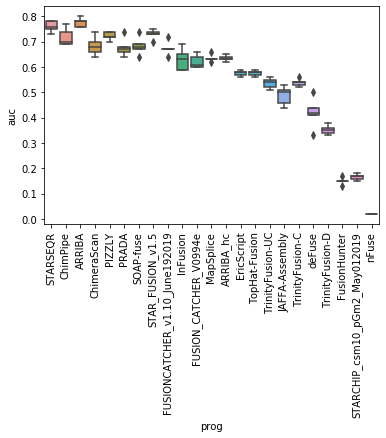

In [22]:
ax = sns.boxplot(x="prog", y="auc", data=auc)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [ ]:
pd.options.display.max_colwidth = 500
mean_auc.sort_values(by='mean_auc', ascending=False)

In [ ]:
(.8-.76)/.76*100

In [ ]:
set.intersection({1, 2}, {2, 3})

In [3]:
import itertools
sets = ['A', 'B', 'C', 'D']
result = []
for i in range(1, len(sets) + 1):
    result += list(itertools.combinations(sets, i))

print(len(result), result)
                

15 [('A',), ('B',), ('C',), ('D',), ('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D'), ('A', 'B', 'C'), ('A', 'B', 'D'), ('A', 'C', 'D'), ('B', 'C', 'D'), ('A', 'B', 'C', 'D')]


In [5]:
combos = []
for i in range(1, len(result) + 1):
    combos += list(itertools.combinations(result, i))
    print(len(combos))
print(len(combos), combos)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

